In [279]:
import cv2
import warnings
import mediapipe as mp
import os
import absl.logging
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Suppress TensorFlow, MediaPipe, and protobuf logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'   # 0 = all logs, 1 = info, 2 = warning, 3 = error only
absl.logging.set_verbosity(absl.logging.ERROR)
warnings.filterwarnings("ignore")

In [280]:

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic
# For webcam input:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as holistic:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = holistic.process(image)
    print(results)
    break

    # Draw landmark annotation on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(
        image,
        results.face_landmarks,
        mp_holistic.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_contours_style())
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles
        .get_default_pose_landmarks_style())

    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Holistic', cv2.flip(image, 1))
    if cv2.waitKey(5) & 0xFF == 27:
      break
cap.release()

I0000 00:00:1762700561.748854   45953 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1762700561.761827   60305 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 25.0.7-0ubuntu0.24.04.2), renderer: AMD Radeon Graphics (radeonsi, renoir, ACO, DRM 3.61, 6.14.0-35-generic)
W0000 00:00:1762700561.904143   60293 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762700561.947429   60295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762700561.950626   60298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762700561.953956   60294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. D

<class 'mediapipe.python.solution_base.SolutionOutputs'>


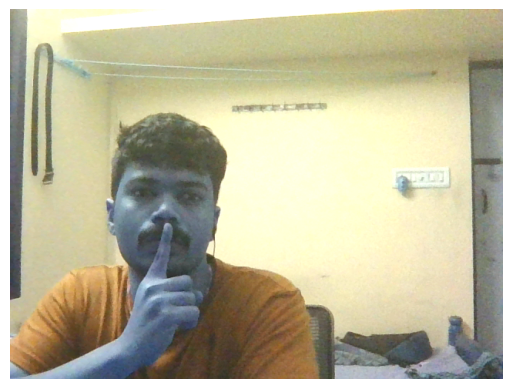

In [281]:

#image = cv2.imread(image)
image = cv2.convertScaleAbs(image, alpha=1.2, beta=25)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()



In [282]:
results.face_landmarks

landmark {
  x: 0.315060169
  y: 0.60778
  z: -0.0294617563
}
landmark {
  x: 0.317910016
  y: 0.567419052
  z: -0.0485193916
}
landmark {
  x: 0.316307515
  y: 0.580892265
  z: -0.0281892661
}
landmark {
  x: 0.31189841
  y: 0.530301869
  z: -0.0333746374
}
landmark {
  x: 0.318771631
  y: 0.555548966
  z: -0.050411243
}
landmark {
  x: 0.319356
  y: 0.540905
  z: -0.0453528315
}
landmark {
  x: 0.320275694
  y: 0.506389141
  z: -0.0173704717
}
landmark {
  x: 0.255291641
  y: 0.502681315
  z: 0.0136958947
}
landmark {
  x: 0.321712673
  y: 0.480184376
  z: -0.00788711291
}
landmark {
  x: 0.322877914
  y: 0.464858115
  z: -0.00750732189
}
landmark {
  x: 0.326245546
  y: 0.412281811
  z: 0.0093519995
}
landmark {
  x: 0.314727783
  y: 0.613175
  z: -0.0287106149
}
landmark {
  x: 0.314109266
  y: 0.617433131
  z: -0.0263762288
}
landmark {
  x: 0.313589692
  y: 0.619333446
  z: -0.0229298733
}
landmark {
  x: 0.313247532
  y: 0.63263756
  z: -0.0191879831
}
landmark {
  x: 0.31305667

In [283]:
results.left_hand_landmarks

In [284]:
results.right_hand_landmarks

landmark {
  x: 0.251733154
  y: 0.904460609
  z: 1.33807376e-07
}
landmark {
  x: 0.26202029
  y: 0.848166943
  z: 0.00661420729
}
landmark {
  x: 0.297798276
  y: 0.798684299
  z: -0.00438076584
}
landmark {
  x: 0.342810422
  y: 0.78224653
  z: -0.0179376844
}
landmark {
  x: 0.378846675
  y: 0.785532355
  z: -0.0317198746
}
landmark {
  x: 0.275596499
  y: 0.745547831
  z: -0.0257680751
}
landmark {
  x: 0.300489038
  y: 0.676845
  z: -0.0442300513
}
landmark {
  x: 0.312965155
  y: 0.627775788
  z: -0.05479794
}
landmark {
  x: 0.318339109
  y: 0.586776912
  z: -0.0620036609
}
landmark {
  x: 0.282165945
  y: 0.75948143
  z: -0.040348582
}
landmark {
  x: 0.357598543
  y: 0.736282647
  z: -0.0577703416
}
landmark {
  x: 0.360604167
  y: 0.774669707
  z: -0.0537854657
}
landmark {
  x: 0.343185
  y: 0.7919451
  z: -0.0483641624
}
landmark {
  x: 0.295280576
  y: 0.790618777
  z: -0.0533504188
}
landmark {
  x: 0.368969649
  y: 0.779153287
  z: -0.0668467954
}
landmark {
  x: 0.3645

# Face landmarks plot 

In [285]:

face = pd.DataFrame(columns=['x', 'y', 'z'])

if results.face_landmarks is not None:
    for i, point in enumerate(results.face_landmarks.landmark):
        face.loc[i] = [point.x, point.y, point.z]

    face['y'] = -face['y']


<Axes: xlabel='x', ylabel='y'>

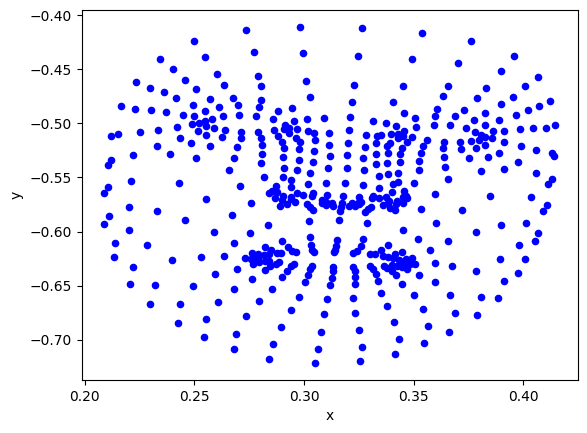

In [286]:
face.plot(x='x',y='y',kind='scatter',color='blue')

In [287]:
# Left hand landmarks

left_hand = pd.DataFrame(columns=['x', 'y', 'z'])

if results.left_hand_landmarks is not None:
    for i, point in enumerate(results.left_hand_landmarks.landmark):
        left_hand.loc[i] = [point.x, point.y, point.z]

    left_hand['y'] = -left_hand['y']

<Axes: xlabel='x', ylabel='y'>

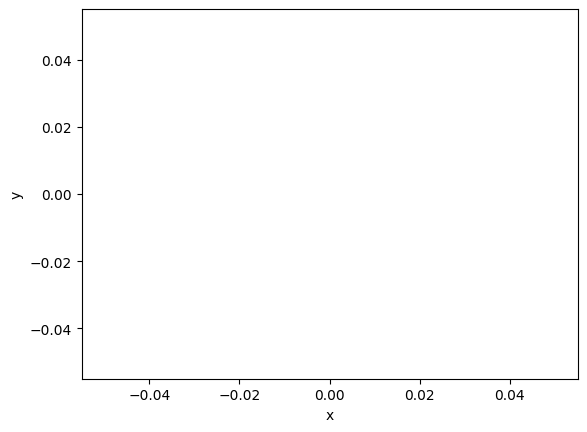

In [288]:
left_hand.plot(x='x',y='y',kind='scatter',color='blue')

In [289]:
#right hand landmarks


right_hand = pd.DataFrame(columns=['x', 'y', 'z'])

if results.right_hand_landmarks is not None:
    for i, point in enumerate(results.right_hand_landmarks.landmark):
        right_hand.loc[i] = [point.x, point.y, point.z]

    right_hand['y'] = -right_hand['y']

<Axes: xlabel='x', ylabel='y'>

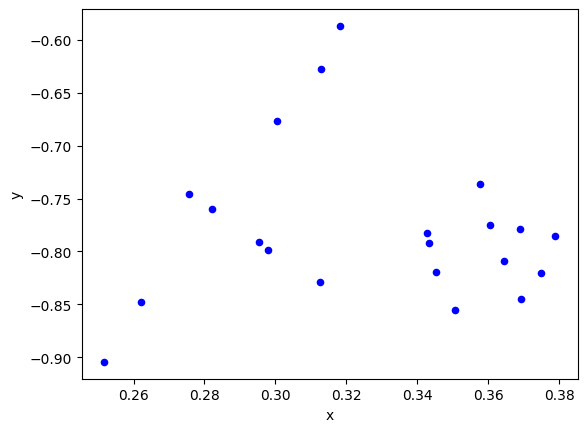

In [290]:
right_hand.plot(x='x',y='y',kind='scatter',color='blue')

In [291]:
#pose landmarks

pose = pd.DataFrame(columns=['x', 'y', 'z'])

if results.pose_landmarks is not None:
    for i, point in enumerate(results.pose_landmarks.landmark):
        pose.loc[i] = [point.x, point.y, point.z]

    pose['y'] = -pose['y']

<Axes: xlabel='x', ylabel='y'>

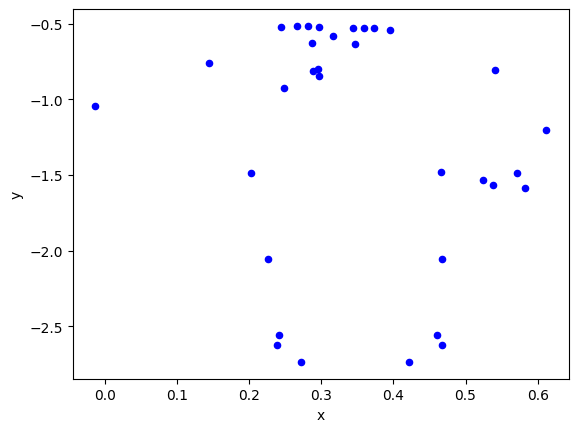

In [292]:
pose.plot(x='x',y='y',kind='scatter',color='blue')

In [293]:
import pandas as pd
import pyarrow

train = pd.read_csv("../asl-signs/train.csv")
pq_file = "../asl-signs/train_landmark_files/16069/10042041.parquet"
xyz = pd.read_parquet(pq_file)

In [294]:
train.query('sequence_id==10042041')

,path,participant_id,sequence_id,sign
101,train_landmark_files/16069/10042041.parquet,16069,10042041,green


In [295]:
xyz['frame'].value_counts()

83     543
136    543
160    543
159    543
158    543
      ... 
115    543
114    543
113    543
112    543
187    543
Name: frame, Length: 105, dtype: int64

In [296]:
#%%
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [297]:
xyz_np = load_relevant_data_subset(pq_file)
xyz_np.shape

(105, 543, 3)

# Make the data taken from cam using mediapipe to the shape we need 

In [298]:
def create_frame_landmark_df(results,frame):
    xyz_skel = (
    xyz[['type', 'landmark_index']]
    .drop_duplicates()
    .reset_index(drop=True)
    .copy()
)

    # initialize empty dataframes
    face = pd.DataFrame()
    pose = pd.DataFrame()
    left_hand = pd.DataFrame()
    right_hand = pd.DataFrame()
    
    # ---- FACE ----
    if results.face_landmarks:
        for i, point in enumerate(results.face_landmarks.landmark):
            face.loc[i, ['x', 'y', 'z']] = [point.x, point.y, point.z]

    # ---- POSE ----
    if results.pose_landmarks:
        for i, point in enumerate(results.pose_landmarks.landmark):
            pose.loc[i, ['x', 'y', 'z']] = [point.x, point.y, point.z]

    # ---- LEFT HAND ----
    if results.left_hand_landmarks:
        for i, point in enumerate(results.left_hand_landmarks.landmark):
            left_hand.loc[i, ['x', 'y', 'z']] = [point.x, point.y, point.z]

    # ---- RIGHT HAND ----
    if results.right_hand_landmarks:
        for i, point in enumerate(results.right_hand_landmarks.landmark):
            right_hand.loc[i, ['x', 'y', 'z']] = [point.x, point.y, point.z]

    
    face = (
    face.reset_index()
    .rename(columns={'index': 'landmark_index'})
    .assign(type='face')
    )

    pose = (
        pose.reset_index()
        .rename(columns={'index': 'landmark_index'})
        .assign(type='pose')
    )

    lefthand = (
        left_hand.reset_index()
        .rename(columns={'index': 'landmark_index'})
        .assign(type='left_hand')
    )
    
    righthand = (
        right_hand.reset_index()
        .rename(columns={'index': 'landmark_index'})
        .assign(type='right_hand')
    )
    landmarks = pd.concat([face,pose,lefthand,righthand]).reset_index(drop=True)
    landmarks = xyz_skel = xyz_skel.merge(landmarks, on=['type', 'landmark_index'], how='left')
    landmarks = landmarks.assign(frame=frame)

    return landmarks

    



In [299]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
landmarks = create_frame_landmark_df(results,0)
landmarks

,type,landmark_index,x,y,z,frame
0,face,0,0.315060,0.607780,-0.029462,0
1,face,1,0.317910,0.567419,-0.048519,0
2,face,2,0.316308,0.580892,-0.028189,0
3,face,3,0.311898,0.530302,-0.033375,0
4,face,4,0.318772,0.555549,-0.050411,0
...,...,...,...,...,...,...
538,right_hand,16,0.345180,0.819005,-0.039301,0
539,right_hand,17,0.312674,0.829190,-0.065896,0
540,right_hand,18,0.374750,0.820074,-0.068643,0
541,right_hand,19,0.369109,0.845290,-0.052074,0


In [300]:
landmarks.reset_index(drop=True).to_parquet("output.parquet")


In [301]:
train['sign'].value_counts()

listen    415
look      414
shhh      411
donkey    410
mouse     408
         ... 
dance     312
person    312
beside    310
vacuum    307
zipper    299
Name: sign, Length: 250, dtype: int64